<a href="https://colab.research.google.com/github/NeevSabhani/Data-Science/blob/main/Unit7/NeevSabhUnit7Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi
!pip install preliz
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb
import pymc as pm

#**Unit 7 Project: Medical Charge Prediction Model**

For this project, I choose to make models that would predict how much a person would pay for a medical visit. Things like how in shape a person is, how old they are, etc, can help us figure out the final amount a hospital would charge you, as for example, older patients usually have more problems than a healthy 20yr old body.

##**Data + Diagram**

In [4]:
import graphviz

causal = graphviz.Digraph(format='png')

causal.node("Age", "Age")
causal.node("Gender", "Gender")
causal.node("dep", "# of Dependents")
causal.node("BMI", "BMI")
causal.node("Smoking", "Smoking")
causal.node("Excercise Frequency", "Excercise Frequency")
causal.node("Dietery Habits", "Dietery Habits")
causal.node("Chronic Diseases", "Chronic Diseases")


causal.node("Genetic Disorders", "Genetic Disorders")
causal.node("Medical Fee", "Medical Fee")


causal.edge("Age", "BMI")
causal.edge("Age", "Chronic Diseases")
causal.edge("Age", "Medical Fee")

causal.edge("Gender", "Chronic Diseases")

causal.edge("dep", "Medical Fee")

causal.edge("BMI", "Chronic Diseases")
causal.edge("BMI", "Medical Fee")

causal.edge("Smoking", "Chronic Diseases")

causal.edge("Excercise Frequency", "BMI")
causal.edge("Excercise Frequency", "Chronic Diseases")

causal.edge("Dietery Habits", "BMI")

causal.edge("Chronic Diseases", "Medical Fee")

causal.edge("Genetic Disorders", "Chronic Diseases")


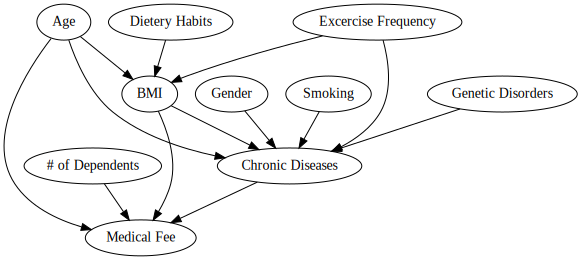

In [5]:
causal

For my data, I will be using a dataset on Kaggle. It had 1500 rows and so I removed 9 rows of every 10 rows using some cheeky Google Sheets technique. I believe this sampling method is called systematic random sampling.

In [3]:
h = pd.read_csv('https://raw.githubusercontent.com/AbdurSharif/data-science-1/refs/heads/main/insurance.csv')
del h['region']
del h['smoker']
del h['sex']

h["children"] = h["children"].astype(int)
h["children"] = h["children"].astype("category")  # Convert to categorical
#print(h["children"].unique())
h


,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
164,47,38.215,4,30407.08585
165,20,37.000,5,24830.63000
166,52,33.155,3,20128.79745
167,49,31.825,1,27019.27975



Medical costs are influenced by a variety of factors, ranging from lifestyle choices to genetic predispositions. However, for this analysis, I have chosen to focus on three key predictors: Age, BMI, and Number of Children. These variables, in my view, have the most direct impact on medical expenses. While other factors, such as smoking status, diet, and exercise habits, certainly play a role, I either found them to be less influential or did not have sufficient data to include them in my models (For example smoking status is a yes or no answer).


---


Age
-  Age is one of the most consistent drivers of medical expenses. As people get older, they are more likely to develop chronic conditions that require ongoing treatment, medication, and specialist visits. Also, screenings and checkups to prevent any of such diseases also increase with age. I believe that medical charges will rise nonlinearly with age.

BMI (Body Mass Index)
-  BMI is a widely used measure of health risk, correlating strongly with obesity-related conditions such as diabetes and cardiovascular disease. People w/ higher BMI often have higher medical expenses due to those things and also have a higher chance of requiring medical help to save their lives. However, very low BMI can also indicate malnourishment or other health complications, which could similarly lead to higher medical costs. I expect both very high and very low BMI values to equal to increased healthcare expenses.

Number of Children
-  While number of children may not seem like an obvious predictor of medical costs, it plays an important role in healthcare expenses for families. Individuals with children are more likely to incur costs related to pregnancy, childbirth, etc. Additionally, having children can impact overall lifestyle, stress levels, and access to medical care, which may influence medical spending.



---


The Models I Chose:


To model medical charges, I will be building six models:

-  Polynomial Model with BMI
-  B-Spline Model with BMI
-  B-Spline Model with BMI and Age
-  B-Spline Model with BMI and Number of Children
-  B-Spline Model with Age and Number of Children
-  B-Spline Model with All Three Predictors

I do believe BMI is the most important indicator, as it literally is a health risk index, so I've done a couple solo predictions with BMI.

Unfortunately, I did not try to mess with GPs (maybe in a later project). They seemed a lot more complicated than B-Splines and I hope that Polynomials and B-splines can get the job done here.


###**Model 1**

In [26]:
model_poly = bmb.Model("charges ~ poly(bmi, degree=4)", h, family="negativebinomial")
idata_poly = model_poly.fit(idata_kwargs={"log_likelihood": True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


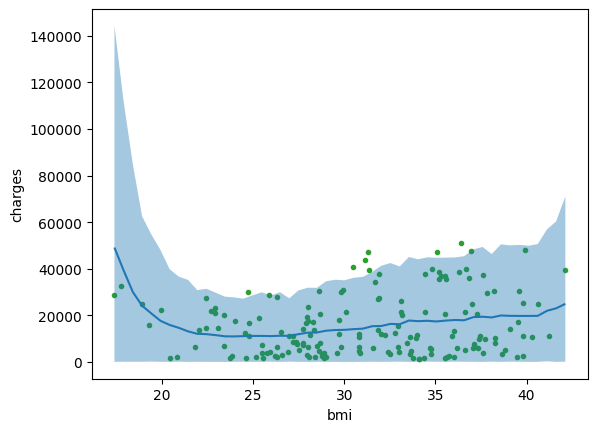

In [27]:
bmb.interpret.plot_predictions(model_poly, idata_poly, "bmi", pps=True)
plt.plot(h.bmi, h.charges, "C2.", zorder=-3)

Compared to the other models ahead, looks wayyy simpler.

###**Model 2**

In [9]:
num_knots = 2
knots = np.linspace(17.39, 45, num_knots+2)[1:-1]
model_b1 = bmb.Model("charges ~ bs(bmi, degree=3, knots=knots)", h, family="negativebinomial")
idata_b1 = model_b1.fit(idata_kwargs={'log_likelihood': True})


Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


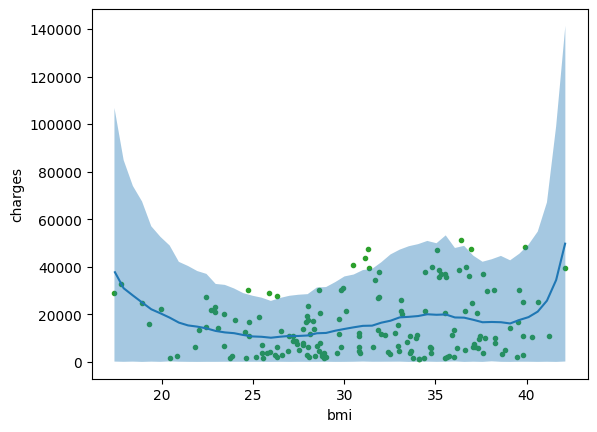

In [10]:
bmb.interpret.plot_predictions(model_b1, idata_b1, "bmi", pps=True)
plt.plot(h.bmi, h.charges, "C2.", zorder=-3)

###**Model 3**

In [11]:
num_knots = 2
knots = np.linspace(17.39, 45, num_knots+2)[1:-1]
knots2 = np.linspace(17, 65, num_knots+2)[1:-1]
model_b2 = bmb.Model("charges ~ bs(bmi, knots=knots) + bs(age, knots=knots2)", h, family="negativebinomial")
idata_b2 = model_b2.fit(idata_kwargs={'log_likelihood': True})


Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


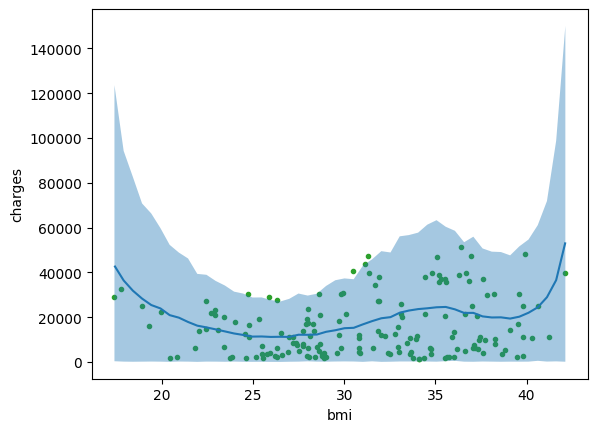

In [12]:
bmb.interpret.plot_predictions(model_b2, idata_b2, "bmi", pps=True)
plt.plot(h.bmi, h.charges, "C2.", zorder=-3)

###**Model 4**

In [13]:
num_knots = 2
knots = np.linspace(17.39, 45, num_knots+2)[1:-1]

h["children"] = h["children"].astype(int)
model_b3 = bmb.Model("charges ~ bs(bmi, knots=knots) + C(children)", h, family="negativebinomial") #children is categorical, not continious
idata_b3 = model_b3.fit(idata_kwargs={'log_likelihood': True})


Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


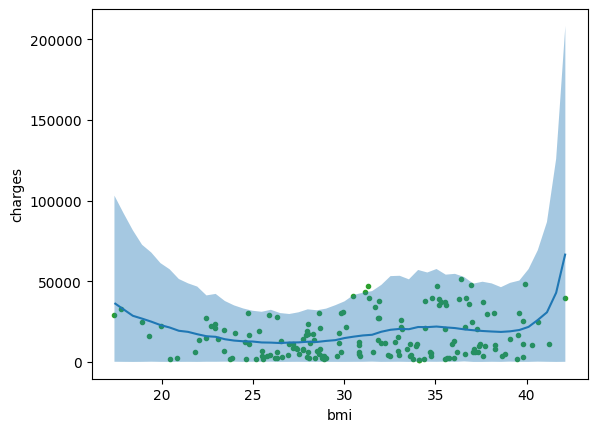

In [14]:
h["children"] = h["children"].astype(int)
bmb.interpret.plot_predictions(model_b3, idata_b3, "bmi", pps=True)
plt.plot(h.bmi, h.charges, "C2.", zorder=-3)


###**Model 5**

In [15]:
num_knots = 2
knots = np.linspace(17, 65, num_knots+2)[1:-1]

h["children"] = h["children"].astype(int)
model_b4 = bmb.Model("charges ~ bs(age, knots=knots) + C(children)", h, family="negativebinomial") #children is categorical, not continious
idata_b4 = model_b4.fit(idata_kwargs={'log_likelihood': True})


Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


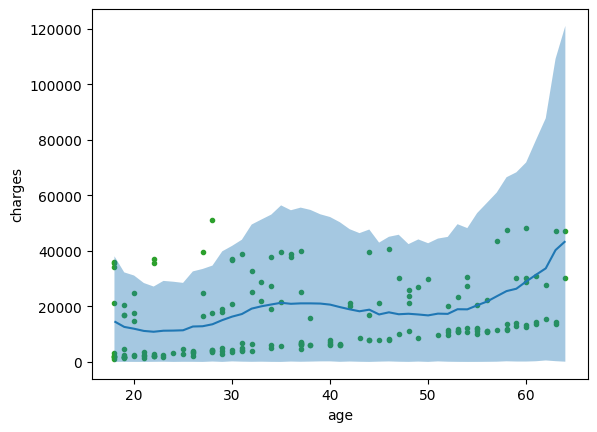

In [83]:
h["children"] = h["children"].astype(int)
bmb.interpret.plot_predictions(model_b4, idata_b4, "age", pps=True)
plt.plot(h.age, h.charges, "C2.", zorder=-3)


The distribution of data points looks pretty odd here.

###**Model 6**

In [16]:
num_knots = 1
knots = np.linspace(17, 65, num_knots+2)[1:-1]
knots2 = np.linspace(17, 65, num_knots+2)[1:-1]

h["children"] = h["children"].astype(int)
model_b5 = bmb.Model("charges ~ bs(bmi, knots=knots) + bs(age, knots=knots2) + C(children)", h, family="negativebinomial") #children is categorical, not continious
idata_b5 = model_b5.fit(idata_kwargs={'log_likelihood': True})


Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


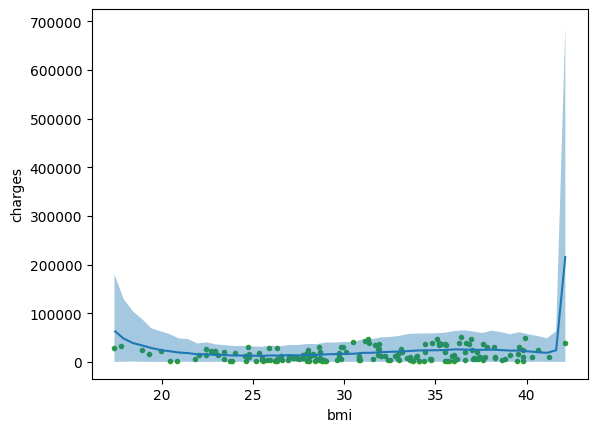

In [17]:
h["children"] = h["children"].astype(int)
bmb.interpret.plot_predictions(model_b5, idata_b5, "bmi", pps=True)
plt.plot(h.bmi, h.charges, "C2.", zorder=-3)

The y-axis goes up to $700k for this one, making it seem super squished. Not completely sure what went wrong.

##**Conclusion**

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

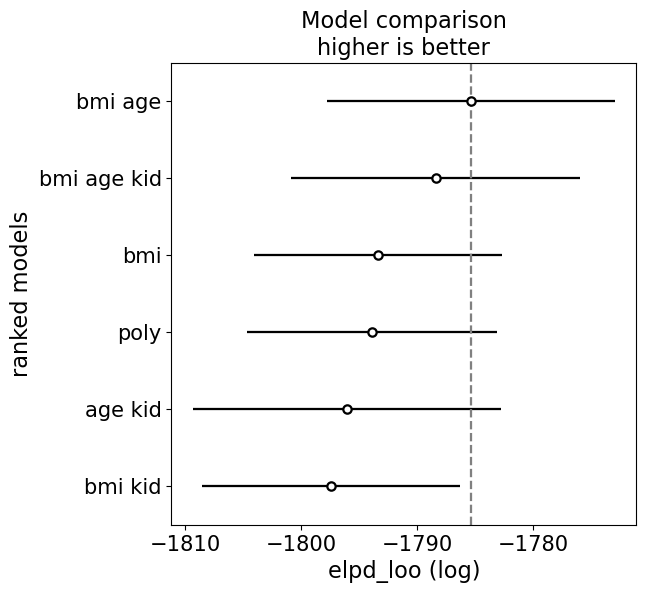

In [19]:
cmp = az.compare({"bmi":idata_b1, "bmi age":idata_b2, "bmi kid":idata_b3,"age kid":idata_b4, "bmi age kid":idata_b5,  "poly":idata_poly})
az.plot_compare(cmp)

# **Conclusion**
We see that the model that was a B-spline with BMI and age interactions has the highest elpd_loo value! To me, this makes sense, as those are the most obvious reasons a person would need to go to the hospital -- they're indicators of a degrading body that needs more medical support.

Something I also noticed was while most models had a slighly more complex 'w' shape, the polynomial model, being simpler than the B-spline models, was more of a v-shape, disregarding the surge of medical charges at ~35 BMI.



---


## **What went wrong with the other models?**
We can go through groups. The models that included kids did pretty badly. While the B-spline that had interactions between all 3 predictors did second best, its clear that including the # of kids someone had was making the predictions worse. I think my initial justification for including # of kids as a predictor wasn't good enough for the model. Additionally, as we can see with the worst performing models of the B-spline of age and kids and the B-spline of BMI and kids, # of kids definetely hindered the model.

I think polynomial and having a B-spline using just BMI as a predictor were just to simple for this dataset, which meant it couldn't accurately predict well enough compared to other models that were given better data. Both of them ran with just the BMI data, even though we see Patient Age being very important in prediction models here.